# 纽约市出租车行程预测
## 一、数据处理
### 1.1 数据来源
除了给定的出租车数据，在网上还找到了一下数据集：
- [出租车行程数据集](https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration)
- [2016年纽约市天气数据](https://www.kaggle.com/datasets/cabaki/knycmetars2016?resource=download)
- [2016年纽约市节假日数据](https://www.kaggle.com/datasets/pceccon/nyc2016holidays)
- [2016年纽约市1KM分辨率人口](https://hub.worldpop.org/geodata/summary?id=80022)



In [32]:
# taxi_travel_time_prediction.ipynb
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
import optuna
import optuna.integration.lightgbm as oplgb

import warnings
warnings.filterwarnings('ignore')

### 1.2读取数据集

In [33]:
# 1.读取训练和预测集
# 参数parse_dates可以解析日期格式
train_df = pd.read_csv('../实习二数据/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
test_df = pd.read_csv('../实习二数据/test.csv', parse_dates=['pickup_datetime'])
dfs = [train_df, test_df]

# 显示数据集的前1行
print(dfs[0].shape, dfs[1].shape)
print("训练集和测试集的前1行数据：")
print(dfs[0].head(1))
print(dfs[1].head(1))

# 2.读取节假日数据
holiday = pd.read_csv('../实习二数据/NYC_2016Holidays.csv', sep=';', parse_dates=['Date'])
# 将假期数据转换为与数据集一致的datetime格式
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i, 'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays[:3]

# 3.读取天气数据
# 读取天气数据
weather = pd.read_csv('../实习二数据/KNYC_Metars.csv', parse_dates=['Time'])
print("天气数据集前一行：")
print(weather.head(1))

(1458644, 11) (625134, 9)
训练集和测试集的前1行数据：
          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0             40.77                  N            455  
          id  vendor_id     pickup_datetime  passenger_count  \
0  id3004672          1 2016-06-30 23:59:58                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0            -73.99            40.73             -73.99             40.76   

  store_and_fwd_flag  
0                  N  
天气数据集前一行：
                 Time  Temp.  Windchill  Heat Index  Humidity  Pressure  \
0 2015-12-31 02:00:00   7.80       7.10         NaN      0.89   1017.00   

   Dew Point  Visibility Wind Dir  Wind Speed  Gust Speed  Precip Ev

## 二、数据清洗

缺失值检查：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
描述性统计：
       vendor_id                pick

<Axes: ylabel='trip_duration'>

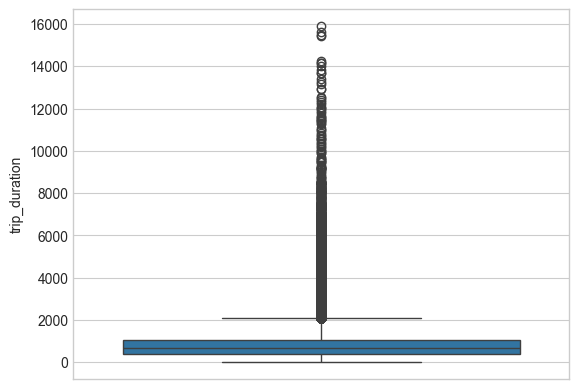

In [34]:
# 1.检查缺失值
print("缺失值检查：")
dfs[0].info() # 根据输出未发现缺失值

# 2.异常值
# 2.1 描述型统计
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("描述性统计：")
print(dfs[0].describe())# 查看描述性统计，发现有不合理的值

# 2.2 passenger_count异常值处理
print("训练集和测试集的passenger_count各种取值数量：")
print(dfs[0].passenger_count.value_counts())
print(dfs[1].passenger_count.value_counts())
for i in range(len(dfs)):
    # TODO: 不如直接删除，以及更优秀的异常值发现方法
    dfs[i]['passenger_count'].replace({
            0:1,7:6,8:6,9:6},inplace=True) # 采用最邻近替换掉异常值0，7，8，9

# 2.3 trip_duration异常值处理
# 查看trip_duration的均值、标准差
time_mean = np.mean(dfs[0].trip_duration)
time_std = np.std(dfs[0].trip_duration)
print(time_mean, time_std)
# 删除异常值
dfs[0] = dfs[0][(dfs[0]['trip_duration']<=(time_mean + 3 * time_std)) & (dfs[0]['trip_duration']>=(time_mean - 3 * time_std))]
# 用正态删除了最大的异常值，但没有删除最小的异常值
# TODO: 最小异常值这样处理还是太简单了
dfs[0] = dfs[0][dfs[0]['trip_duration']!=1]
sns.boxplot(dfs[0]['trip_duration'])# 查看去除异常值后的trip_duration分布

## 三、特征工程与EDA
### 3.1 时间特征

- 由上面的分析可以发现，trip_duration的标准差为5237.43，说明行程时间数据差异大，为减小数据差异带来的干扰，将数据log化：log_trip_duration
- 提取时间特征
- 是否是工作日、节假日
- 将时段分为早晚高峰、白天、夜晚

log_trip_duration分布：


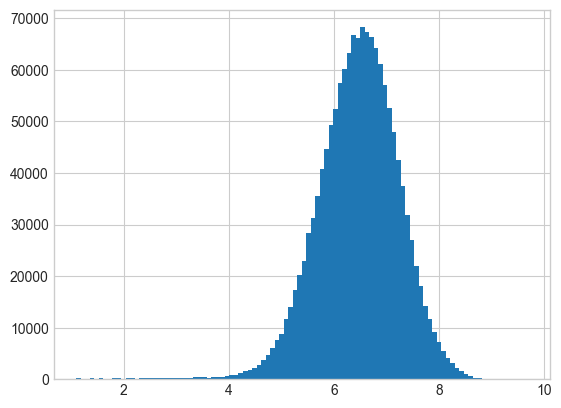

In [35]:
# 3.1 log_trip_duration取对数
dfs[0]['log_trip_duration'] = np.log(dfs[0]['trip_duration'].values + 1)
print("log_trip_duration分布：")
plt.hist(dfs[0]['log_trip_duration'].values, bins=100)
plt.show()

# 3.2 提取时间特征
# 提取年、月、日、小时、分钟、星期、日期
for i, d in enumerate(dfs):
    dfs[i]['year'] = d.pickup_datetime.dt.year
    dfs[i]['month'] = d.pickup_datetime.dt.month
    dfs[i]['day'] = d.pickup_datetime.dt.day
    dfs[i]['hour'] = d.pickup_datetime.dt.hour
    dfs[i]['minute'] = d.pickup_datetime.dt.minute
    dfs[i]['dayofweek'] = d.pickup_datetime.dt.dayofweek
    dfs[i]['date'] = d.pickup_datetime.dt.date
    dfs[i]['time'] = d.hour + d.minute/60

# 判断是否工作日、是否节假日
for i, d in enumerate(dfs):
    dfs[i]['is_weekend'] = d['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)
    dfs[i]['is_rest'] = d['date'].apply(lambda x: 1 if x in holidays else 0)

# 24小时切分为不同时段：早高峰、晚高峰、白天、夜晚
def get_time_interval(series):
    hour = series['hour']
    is_rest = series['is_rest']
    
    if is_rest==1:
        if hour>=7 and hour<=21:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    elif is_rest==0:
        if hour>=7 and hour<=9: 
            time_interval='morning_peak'
        elif hour>=17 and hour<=21:
            time_interval='evening_peak'
        elif hour>9 and hour<17:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    return time_interval

for i, d in enumerate(dfs):
    dfs[i]['time_interval'] = d.apply(get_time_interval, axis=1)



### 3.2 天气特征  

In [36]:
# 3.3 天气特征
print("各类天气数量：")
print(weather.Events.value_counts())
# 将天气加上时间标签：
# 提取天气特征的年月日等时间特征，并筛选年份天气等特征。
weather['year'] = weather.Time.dt.year
weather['month'] = weather.Time.dt.month
weather['day'] = weather.Time.dt.day
weather['hour'] = weather.Time.dt.hour
weather['events_weather'] = weather['Events'].apply(lambda x: 0 if x=='None' else 1)
weather = weather[weather['year']==2016][['Temp.', 'Visibility', 'events_weather', 'month', 'day','hour', 'Precip']]
# 与上车时间合并
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, weather, on=['month', 'day', 'hour'], how='left')

各类天气数量：
Events
Rain              377
Snow               51
Fog\n\t,\nSnow     23
Fog                 2
Fog\n\t,\nRain      2
Name: count, dtype: int64


### 3.3 距离特征

In [37]:
# 计算经纬度之间的距离
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return round(c * 6371, 3) # 地球平均半径，6371km

# 单位：km
for i, d in enumerate(dfs):
    dfs[i]['haversine'] = d.apply(lambda x: haversine(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

### 3.4 区域特征
- 对经纬度用kmeans聚类，创建区域特征分为15个类别：(感觉不太好)
数据集太大，所以用MiniBatchKMeans代替，能够对小规模子集进行计算，减少计算时间。
- 对经纬度用PCA，创建新特征

In [38]:
# TODO：将聚类的聚类编号变为行政区
# 先将所有需要转换的数据汇总，一起放入fit
coords = np.vstack((dfs[0][['pickup_longitude', 'pickup_latitude']].values,
                    dfs[0][['dropoff_longitude', 'dropoff_latitude']].values,
                    dfs[1][['pickup_longitude', 'pickup_latitude']].values,
                    dfs[1][['dropoff_longitude', 'dropoff_latitude']].values))
# 随机采样
sample_ids = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=15, batch_size=10000).fit(coords[sample_ids])

# 聚类
for i, d in enumerate(dfs):
    dfs[i]['pickup_cluster'] = kmeans.predict(d[['pickup_longitude', 'pickup_latitude']])
    dfs[i]['dropoff_cluster'] = kmeans.predict(d[['dropoff_longitude', 'dropoff_latitude']])

print(pd.concat([dfs[0], dfs[1]]).groupby(['pickup_cluster']).size().reset_index())

# PCA
pca = PCA().fit(coords)
for i, d in enumerate(dfs):
    dfs[i]['pickup_pca0'] = pca.transform(d[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dfs[i]['pickup_pca1'] = pca.transform(d[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dfs[i]['dropoff_pca0'] = pca.transform(d[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dfs[i]['dropoff_pca1'] = pca.transform(d[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

    pickup_cluster       0
0                0  246961
1                1    2000
2                2  148099
3                3   17148
4                4  311845
5                5  106542
6                6   59135
7                7  259989
8                8   46292
9                9   19878
10              10  273718
11              11  306255
12              12   35379
13              13    1152
14              14  247279


### 3.5 速度
- 根据haversine距离与trip_duration计算车速：speed=haversine(km)×1000/trip_duration，单位m/s
- 由于test无法计算haversine speed，所以根据haversine speed计算每个区域的平均速度

In [39]:
# 计算haversine车速
dfs[0]['speed'] = dfs[0]['haversine'] * 1000 / dfs[0]['trip_duration']
pickup_speed = dfs[0][['speed', 'pickup_cluster']].groupby('pickup_cluster').mean().reset_index()
pickup_speed.rename(columns={
            'speed': 'avg_pickup_speed'}, inplace=True)
dropoff_speed = dfs[0][['speed', 'dropoff_cluster']].groupby('dropoff_cluster').mean().reset_index()
dropoff_speed.rename(columns={
            'speed': 'avg_dropoff_speed'}, inplace=True)

# 计算区域的平均速度
# 并合并到train和test
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, pickup_speed, on=['pickup_cluster'], how='left')
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, dropoff_speed, on=['dropoff_cluster'], how='left')

print(dfs[0].drop('speed', axis = 1, inplace=True))

None


### 3.6 人口特征


In [40]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import rowcol

# --------------------------
# 1. 核心函数：根据经纬度提取人口密度
# --------------------------
def get_population_density(tif_path, lon, lat):
    """通用函数：根据经纬度（lon, lat）提取对应位置的人口密度"""
    with rasterio.open(tif_path) as src:
        # 经纬度转TIF行列索引
        rows, cols = rowcol(src.transform, lon, lat)
        
        # 索引边界处理
        rows = np.clip(rows, 0, src.height - 1)
        cols = np.clip(cols, 0, src.width - 1)
        
        # 读取人口密度（假设第1波段为密度值）
        pop_density = src.read(1)[rows, cols]
        
        # 处理无效值（NoData）
        nodata = src.nodata if src.nodata is not None else -9999
        pop_density = np.where(pop_density == nodata, np.nan, pop_density)
        
        # 用整体平均值填充缺失
        mean_density = np.nanmean(pop_density)
        return np.nan_to_num(pop_density, nan=mean_density)

# --------------------------
# 2. 添加上车点+下车点人口密度特征
# --------------------------
# 替换为你的NYC人口TIF路径
NYC_POP_TIF = "../实习二数据/nyc_population_2016.tif"  # 例如："nyc_pop_raster.tif"

# 遍历所有数据框（train/test）
for i in range(len(dfs)):
    # 1. 上车点人口密度
    pickup_lon = dfs[i]['pickup_longitude'].values
    pickup_lat = dfs[i]['pickup_latitude'].values
    dfs[i]['pickup_pop_density'] = get_population_density(NYC_POP_TIF, pickup_lon, pickup_lat)
    
    # 2. 下车点人口密度
    dropoff_lon = dfs[i]['dropoff_longitude'].values
    dropoff_lat = dfs[i]['dropoff_latitude'].values
    dfs[i]['dropoff_pop_density'] = get_population_density(NYC_POP_TIF, dropoff_lon, dropoff_lat)

# --------------------------
# 3. 检查结果
# --------------------------
print("添加上下车点人口密度后的前5行数据：")
print(dfs[0][[
    'id', 'pickup_longitude', 'pickup_latitude', 'pickup_pop_density',
    'dropoff_longitude', 'dropoff_latitude', 'dropoff_pop_density',
    'trip_duration'
]].head())

添加上下车点人口密度后的前5行数据：
          id  pickup_longitude  pickup_latitude  pickup_pop_density  \
0  id2875421            -73.98            40.77            11674.00   
1  id2377394            -73.98            40.74            32831.08   
2  id3858529            -73.98            40.76            10337.24   
3  id3504673            -74.01            40.72             9841.03   
4  id2181028            -73.97            40.79            36603.33   

   dropoff_longitude  dropoff_latitude  dropoff_pop_density  trip_duration  
0             -73.96             40.77             29462.14            455  
1             -74.00             40.73             20344.47            663  
2             -74.01             40.71             15132.38           2124  
3             -74.01             40.71              8950.64            429  
4             -73.97             40.78               969.62            435  


### 3.7 分类变量转换
- store_and_fwd_flag、time_interval，进行dummy操作

In [41]:
for i, d in enumerate(dfs):
    store_and_fwd_flag_dummy = pd.get_dummies(d.store_and_fwd_flag, prefix='sff', prefix_sep='_')
    time_interval_dummy = pd.get_dummies(d.time_interval, prefix='ti', prefix_sep='_')

    dfs[i] = pd.concat([d, store_and_fwd_flag_dummy, time_interval_dummy], axis = 1)

## 四、探索性分析

In [42]:
# TODO: 探索性分析

## 五、建模

### 5.1 划分数据集

In [43]:
# 5.1.1 指定特征
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 
            'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'month', 'day', 'hour', 
            'minute', 'dayofweek', 'time', 'is_weekend', 
            'is_rest', 'Temp.', 'Visibility', 
            'events_weather', 'Precip', 'haversine', 
            'pickup_cluster', 'dropoff_cluster', 
            'avg_pickup_speed', 'avg_dropoff_speed', 'sff_N', 
            'sff_Y', 'ti_day', 'ti_morning_peak', 'ti_night', 'ti_evening_peak', 'pickup_pca0', 'pickup_pca1',
            'dropoff_pca0', 'dropoff_pca1','pickup_pop_density','dropoff_pop_density']

# 划分数据集
RANDOM_SEED = 42
X = dfs[0][features]
y = dfs[0]['log_trip_duration']
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### 5.2 评价指标

In [44]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

### 5.3LightGBM模型训练

#### 5.3.1 超参数最优化

In [45]:
from lightgbm import early_stopping, LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import numpy as np

# 假设你已定义 RANDOM_SEED、train_X、val_X、rmsle 等变量

def objective(trial):
    param = {
        'random_state': RANDOM_SEED, 
        'n_estimators': 1000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)      
    }
    
    lgb = LGBMRegressor(**param)
    lgb.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        callbacks=[early_stopping(stopping_rounds=20,verbose=False)]
    )
    pred_lgb = lgb.predict(val_X)
    return rmsle(val_y, pred_lgb)

# 执行超参数搜索
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())



[I 2025-10-22 23:18:03,100] A new study created in memory with name: no-name-72b37b27-d982-412c-9c9a-915a7e2a5a22


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:18:59,995] Trial 0 finished with value: 0.05456138485204687 and parameters: {'reg_alpha': 0.42599497118242435, 'reg_lambda': 0.20775588947550205, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 155, 'min_child_samples': 3, 'cat_smooth': 17}. Best is trial 0 with value: 0.05456138485204687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 23:19:47,614] Trial 1 finished with value: 0.05523498318145223 and parameters: {'reg_alpha': 0.15678976681626772, 'reg_lambda': 5.868368895710491, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 9, 'num_leaves': 220, 'min_child_samples': 153, 'cat_smooth': 97}. Best is trial 0 with value: 0.05456138485204687.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:20:59,897] Trial 2 finished with value: 0.054034763280874386 and parameters: {'reg_alpha': 0.28162976553636393, 'reg_lambda': 0.3083067288022771, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 331, 'min_child_samples': 220, 'cat_smooth': 95}. Best is trial 2 with value: 0.054034763280874386.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:21:55,252] Trial 3 finished with value: 0.05857865028293506 and parameters: {'reg_alpha': 0.01940923864928752, 'reg_lambda': 0.0010657297467606523, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 7, 'num_leaves': 104, 'min_child_samples': 55, 'cat_smooth': 13}. Best is trial 2 with value: 0.054034763280874386.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:23:05,403] Trial 4 finished with value: 0.053371979994966234 and parameters: {'reg_alpha': 0.00763007273588714, 'reg_lambda': 8.248256616430233, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 244, 'min_child_samples': 210, 'cat_smooth': 33}. Best is trial 4 with value: 0.053371979994966234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:23:58,675] Trial 5 finished with value: 0.05838331743791984 and parameters: {'reg_alpha': 0.268712730309311, 'reg_lambda': 7.036131549791364, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 7, 'num_leaves': 747, 'min_child_samples': 263, 'cat_smooth': 31}. Best is trial 4 with value: 0.053371979994966234.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 23:24:53,674] Trial 6 finished with value: 0.05494190682460157 and parameters: {'reg_alpha': 0.1029507391505618, 'reg_lambda': 1.6413101189972086, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 11, 'num_leaves': 173, 'min_child_samples': 244, 'cat_smooth': 22}. Best is trial 4 with value: 0.053371979994966234.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:26:19,322] Trial 7 finished with value: 0.05521904965055675 and parameters: {'reg_alpha': 0.005284861653404934, 'reg_lambda': 0.03202436772788497, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 15, 'num_leaves': 334, 'min_child_samples': 190, 'cat_smooth': 31}. Best is trial 4 with value: 0.053371979994966234.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-22 23:26:58,534] Trial 8 finished with value: 0.05811636929347908 and parameters: {'reg_alpha': 0.0025156886415022162, 'reg_lambda': 0.017051567321466465, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 535, 'min_child_samples': 143, 'cat_smooth': 73}. Best is trial 4 with value: 0.053371979994966234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:28:40,293] Trial 9 finished with value: 0.05295907151222562 and parameters: {'reg_alpha': 9.905977752771157, 'reg_lambda': 7.0407398336832845, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 50, 'num_leaves': 362, 'min_child_samples': 13, 'cat_smooth': 39}. Best is trial 9 with value: 0.05295907151222562.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:31:17,428] Trial 10 finished with value: 0.052318515894638144 and parameters: {'reg_alpha': 9.778872972237185, 'reg_lambda': 1.0960231026073717, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 997, 'min_child_samples': 73, 'cat_smooth': 61}. Best is trial 10 with value: 0.052318515894638144.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:34:04,330] Trial 11 finished with value: 0.05234955017078555 and parameters: {'reg_alpha': 9.673226999001374, 'reg_lambda': 0.9093185272125066, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 934, 'min_child_samples': 60, 'cat_smooth': 57}. Best is trial 10 with value: 0.052318515894638144.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:37:02,583] Trial 12 finished with value: 0.052338759357771415 and parameters: {'reg_alpha': 9.492216371318332, 'reg_lambda': 0.8172731090607096, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 996, 'min_child_samples': 80, 'cat_smooth': 60}. Best is trial 10 with value: 0.052318515894638144.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:39:32,285] Trial 13 finished with value: 0.05225946615709165 and parameters: {'reg_alpha': 1.9095979114852009, 'reg_lambda': 0.8959125706260292, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 986, 'min_child_samples': 98, 'cat_smooth': 60}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:41:53,306] Trial 14 finished with value: 0.05231444091571201 and parameters: {'reg_alpha': 1.3152965761182098, 'reg_lambda': 0.0565800303194701, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 821, 'min_child_samples': 117, 'cat_smooth': 81}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:42:34,625] Trial 15 finished with value: 0.05934903186029384 and parameters: {'reg_alpha': 1.2560252719687042, 'reg_lambda': 0.03729226067908826, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 5, 'num_leaves': 773, 'min_child_samples': 118, 'cat_smooth': 79}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:44:55,394] Trial 16 finished with value: 0.05382357078048807 and parameters: {'reg_alpha': 1.0354944993555515, 'reg_lambda': 0.005723147021231004, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 820, 'min_child_samples': 109, 'cat_smooth': 78}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:46:42,186] Trial 17 finished with value: 0.05256373959504054 and parameters: {'reg_alpha': 1.7059106198367147, 'reg_lambda': 0.11434775779255367, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 572, 'min_child_samples': 179, 'cat_smooth': 1}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-22 23:48:38,643] Trial 18 finished with value: 0.05271319379221235 and parameters: {'reg_alpha': 2.8163478090859257, 'reg_lambda': 0.004751870351026055, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 663, 'min_child_samples': 297, 'cat_smooth': 47}. Best is trial 13 with value: 0.05225946615709165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303


[I 2025-10-22 23:49:04,686] Trial 19 finished with value: 0.05910023166612566 and parameters: {'reg_alpha': 0.03634758905963625, 'reg_lambda': 0.38975805136847874, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'num_leaves': 9, 'min_child_samples': 111, 'cat_smooth': 87}. Best is trial 13 with value: 0.05225946615709165.


Best trial: {'reg_alpha': 1.9095979114852009, 'reg_lambda': 0.8959125706260292, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'num_leaves': 986, 'min_child_samples': 98, 'cat_smooth': 60}
------------------------------------------------
    number  value             datetime_start          datetime_complete  \
0        0   0.05 2025-10-22 23:18:03.103563 2025-10-22 23:18:59.994442   
1        1   0.06 2025-10-22 23:18:59.995439 2025-10-22 23:19:47.614204   
2        2   0.05 2025-10-22 23:19:47.616202 2025-10-22 23:20:59.897446   
3        3   0.06 2025-10-22 23:20:59.899443 2025-10-22 23:21:55.252549   
4        4   0.05 2025-10-22 23:21:55.253525 2025-10-22 23:23:05.403595   
5        5   0.06 2025-10-22 23:23:05.404601 2025-10-22 23:23:58.675370   
6        6   0.05 2025-10-22 23:23:58.676957 2025-10-22 23:24:53.673836   
7        7   0.06 2025-10-22 23:24:53.675836 2025-10-22 23:26:19.320996   
8        8   0.06 2025-10-22 23:26:19.322747 2025-1

#### 5.3.2 模型训练

In [46]:
# 使用最优参数重新训练模型（用于获取特征重要性）
best_model = LGBMRegressor(** study.best_trial.params)
best_model.fit(
    train_X, train_y,
    eval_set=[(val_X, val_y)],
    callbacks=[early_stopping(stopping_rounds=20)]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.149882


,boosting_type,'gbdt'
,num_leaves,986
,max_depth,17
,learning_rate,0.02
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,98


### 5.4 模型分析

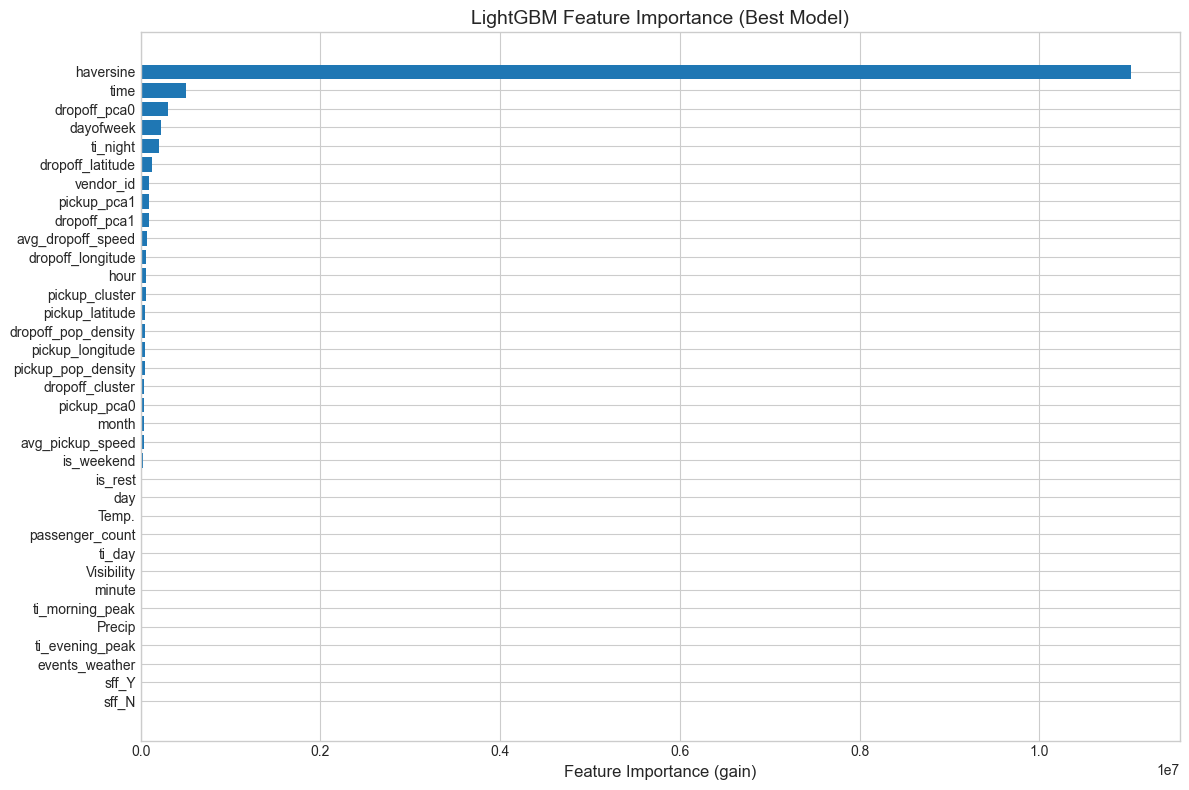

In [47]:
# 5.4.1 特征重要性可视化
# 获取特征名称（假设train_X是DataFrame，若为numpy数组可手动指定特征名）
feature_names = train_X.columns if hasattr(train_X, 'columns') else [f'feature_{i}' for i in range(train_X.shape[1])]

# 获取特征重要性（兼容sklearn接口的LightGBM）
importance_type = 'gain'  # 'split'表示分裂次数，'gain'表示总增益（更推荐）
# 关键修正：通过booster_获取底层模型，调用feature_importance方法
feature_importance = best_model.booster_.feature_importance(importance_type=importance_type)

# 排序特征重要性
sorted_idx = np.argsort(feature_importance)[::-1]  # 从高到低排序
sorted_importance = feature_importance[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=10)
plt.xlabel(f'Feature Importance ({importance_type})', fontsize=12)
plt.title('LightGBM Feature Importance (Best Model)', fontsize=14)
plt.gca().invert_yaxis()  # 让最重要的特征在顶部
plt.tight_layout()  # 调整布局避免文字截断
plt.show()

验证集预测结果（原始时间单位，前5行）：
   真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
0   815.00   627.24   187.76  0.23
1   499.00   552.23    53.23  0.11
2  1351.00   873.67   477.33  0.35
3  1642.00  1099.16   542.84  0.33
4   236.00   220.26    15.74  0.07

【原始时间单位评估指标】（核心关注）
平均绝对时间差距：204.23 秒
均方根时间差距：354.46 秒
平均相对误差：32.38%
------------------------------------------------------------
【log尺度评估指标】（模型拟合参考）
log尺度RMSE：0.3871
log尺度R²：0.7490



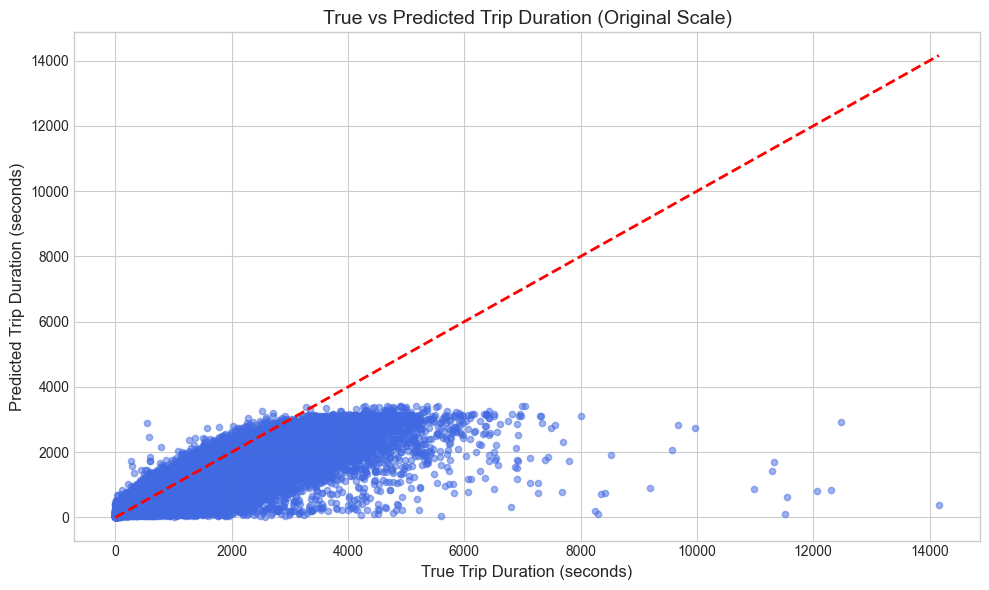

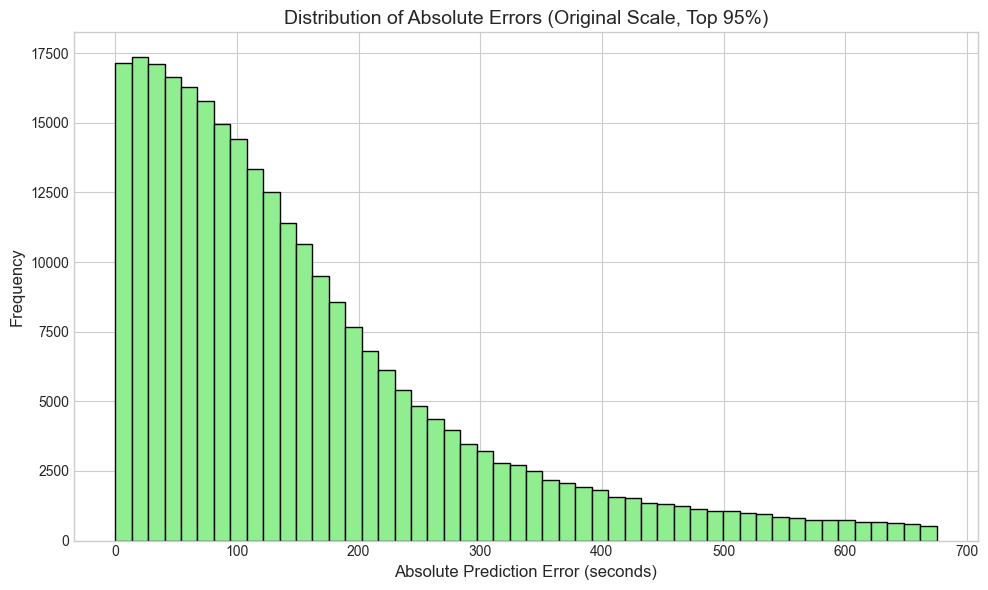

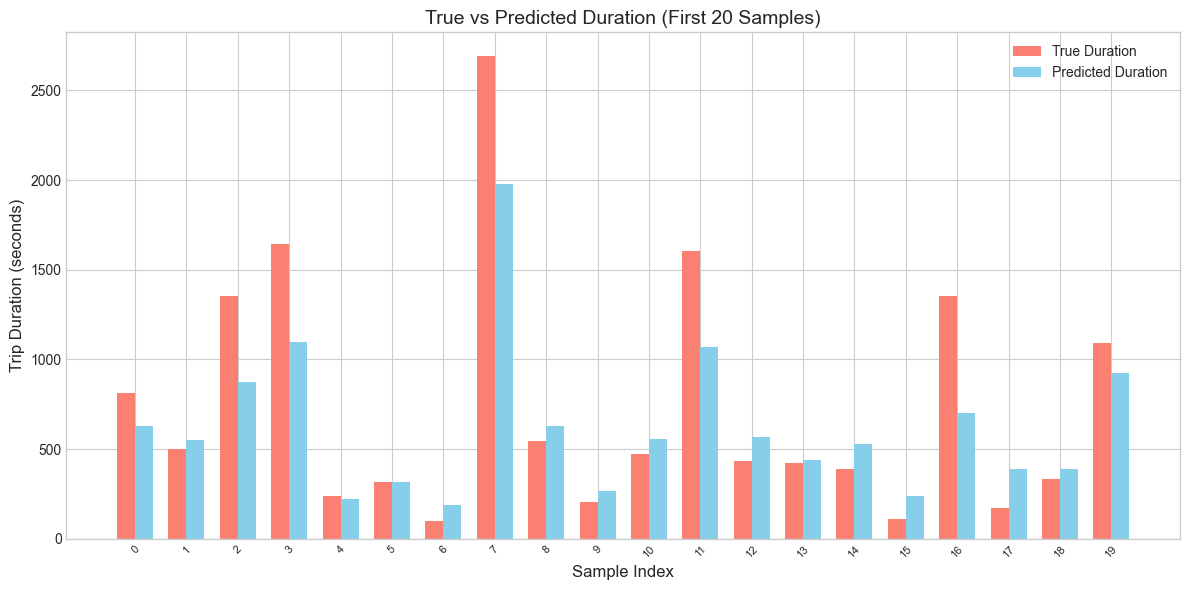

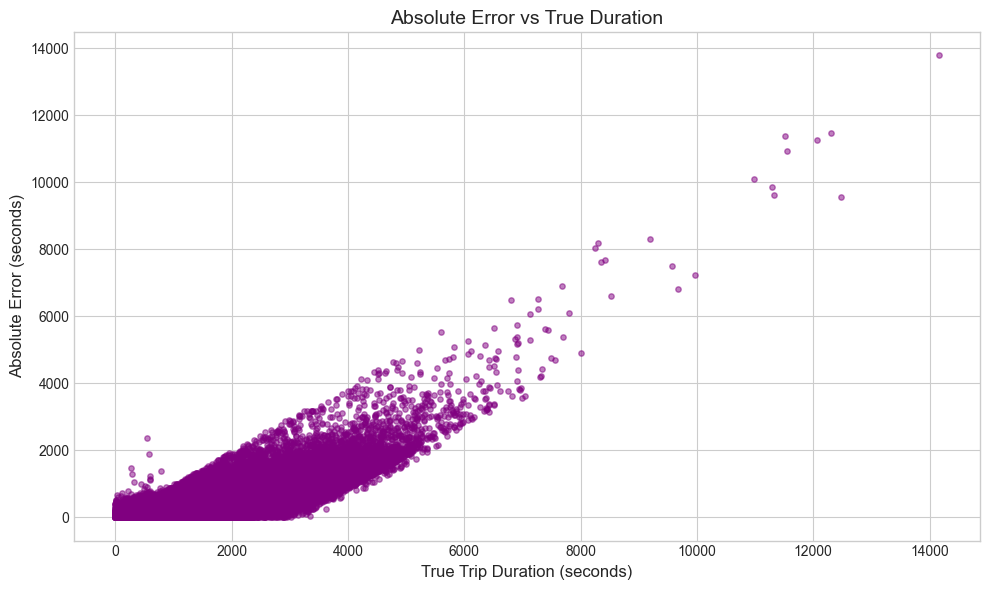


误差最大的10个样本（原始时间单位）：
        真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
108161 14160.00   371.44 13788.56  0.97
68410  12313.00   831.42 11481.58  0.93
123068 11513.00   115.01 11397.99  0.99
256599 12064.00   798.23 11265.77  0.93
208187 11556.00   626.67 10929.33  0.95
1878   10981.00   870.22 10110.78  0.92
117816 11295.00  1438.79  9856.21  0.87
194128 11332.00  1694.98  9637.02  0.85
84315  12480.00  2914.30  9565.70  0.77
285448  9198.00   896.37  8301.63  0.90


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------
# 1. 生成验证集预测结果（含逆转换）
# --------------------------
# 1.1 用最佳模型预测验证集（log尺度）
val_pred_log = best_model.predict(val_X)  # 预测的是log_trip_duration
val_true_log = val_y.values              # 真实的log_trip_duration

# 1.2 逆转换：从log尺度还原为原始时间（trip_duration）
# 抵消之前的 log(x + 1) → 逆运算为 exp(log_x) - 1
val_pred = np.exp(val_pred_log) - 1  # 预测的原始时间（如秒）
val_true = np.exp(val_true_log) - 1  # 真实的原始时间（如秒）

# 1.3 整理结果（原始时间单位）
result_df = pd.DataFrame({
    '真实时间（秒）': val_true,
    '预测时间（秒）': val_pred,
    '绝对误差（秒）': np.abs(val_pred - val_true),  # 绝对差距
    '相对误差': np.abs(val_pred - val_true) / (val_true + 1e-6)  # 相对差距（加1e-6避免除0）
})
print("验证集预测结果（原始时间单位，前5行）：")
print(result_df.head())


# --------------------------
# 2. 计算量化评估指标（原始时间+log尺度）
# --------------------------
# 2.1 原始时间单位的指标（更关注这个，反映实际差距）
mae_time = mean_absolute_error(val_true, val_pred)  # 平均绝对时间差距（秒）
rmse_time = np.sqrt(mean_squared_error(val_true, val_pred))  # 均方根时间差距（秒）
mean_rel_error = result_df['相对误差'].mean() * 100  # 平均相对误差（百分比）

# 2.2 log尺度的指标（参考，用于对比模型拟合效果）
rmse_log = np.sqrt(mean_squared_error(val_true_log, val_pred_log))
r2_log = r2_score(val_true_log, val_pred_log)

print("\n" + "="*60)
print("【原始时间单位评估指标】（核心关注）")
print(f"平均绝对时间差距：{mae_time:.2f} 秒")  # 平均差多少秒
print(f"均方根时间差距：{rmse_time:.2f} 秒")    # 反映整体误差波动
print(f"平均相对误差：{mean_rel_error:.2f}%")  # 平均误差占真实时间的百分比
print("-"*60)
print("【log尺度评估指标】（模型拟合参考）")
print(f"log尺度RMSE：{rmse_log:.4f}")
print(f"log尺度R²：{r2_log:.4f}")
print("="*60 + "\n")


# --------------------------
# 3. 可视化预测结果（原始时间单位）
# --------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# 3.1 真实时间vs预测时间散点图（判断整体趋势）
plt.figure(figsize=(10, 6))
plt.scatter(val_true, val_pred, alpha=0.5, s=20, color='royalblue')
# 添加参考线（y=x表示预测完全准确）
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('True Trip Duration (seconds)', fontsize=12)
plt.ylabel('Predicted Trip Duration (seconds)', fontsize=12)
plt.title('True vs Predicted Trip Duration (Original Scale)', fontsize=14)
plt.tight_layout()
plt.show()


# 3.2 绝对误差分布直方图（分析误差大小分布）
plt.figure(figsize=(10, 6))
# 可选：过滤极端大误差（让分布更清晰）
filtered_errors = result_df['绝对误差（秒）'][result_df['绝对误差（秒）'] < np.percentile(result_df['绝对误差（秒）'], 95)]
plt.hist(filtered_errors, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Absolute Prediction Error (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Absolute Errors (Original Scale, Top 95%)', fontsize=14)
plt.tight_layout()
plt.show()


# 3.3 前20个样本的真实值vs预测值对比（个体差异）
plt.figure(figsize=(12, 6))
sample_df = result_df.head(20)  # 取前20个样本
x = np.arange(len(sample_df))
width = 0.35

plt.bar(x - width/2, sample_df['真实时间（秒）'], width, label='True Duration', color='salmon')
plt.bar(x + width/2, sample_df['预测时间（秒）'], width, label='Predicted Duration', color='skyblue')

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Trip Duration (seconds)', fontsize=12)
plt.title('True vs Predicted Duration (First 20 Samples)', fontsize=14)
plt.xticks(x, sample_df.index, rotation=45, fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()


# 3.4 误差随真实时间的变化（看是否某些区间误差更大）
plt.figure(figsize=(10, 6))
plt.scatter(val_true, result_df['绝对误差（秒）'], alpha=0.5, s=15, color='purple')
plt.xlabel('True Trip Duration (seconds)', fontsize=12)
plt.ylabel('Absolute Error (seconds)', fontsize=12)
plt.title('Absolute Error vs True Duration', fontsize=14)
plt.tight_layout()
plt.show()


# --------------------------
# 4. 误差较大样本分析（原始时间单位）
# --------------------------
# 按绝对误差排序，取误差最大的10个样本
top_error_samples = result_df.sort_values(by='绝对误差（秒）', ascending=False).head(10)
print("\n误差最大的10个样本（原始时间单位）：")
print(top_error_samples[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']])

# （可选）查看这些样本的特征，分析误差原因
# print("\n误差最大样本的特征：")
# print(val_X.loc[top_error_samples.index])